# black-box regression results

Generates figures comparing performance on the black-box regression problems.

In [36]:
import pandas as pd
import json
import numpy as np
from glob import glob
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rc('pdf', fonttype=42)
import os
sns.set(font_scale=1.25, style='whitegrid')

rdir = '../results_pmlb_r1/'
figdir = '../../paper/figs/' + rdir.replace('..','')
print('figdir:',figdir)
def save(h=None,name='tmp'):
    name = name.strip().replace(' ','-').replace('%','pct')
    if h == None:
        h = plt.gcf()
    h.tight_layout()
    print('saving',figdir+'/'+name+'.pdf')
    if not os.path.exists(figdir):
        os.makedirs(figdir)
    plt.savefig(figdir+'/'+name+'.pdf', bbox_inches='tight')
    
symbolic_algs = [
    'AFP', 
    'AFP_FE',
    'BSR',
    'DSR',
    'FFX',
    'FEAT',
    'EPLEX',
    'GP-GOMEA',
    'gplearn',
    'ITEA', 
    'MRGP', 
    'Operon',
    'SBP-GP',
    'AIFeynman'
]
nongp_algs = [
    'BSR',
    'DSR',
    'AIFeynman'
]
gp_algs = [
    'AFP', 
    'AFP_FE',
    'FFX',
    'FEAT',
    'EPLEX',
    'GP-GOMEA',
    'gplearn',
    'ITEA', 
    'MRGP', 
    'Operon',
    'SBP-GP',
]

figdir: ../../paper/figs//results_pmlb_r1/


# load data from json

In [2]:
frames = []
comparison_cols = [
    'dataset',
    'algorithm',
    'random_state',
    'time_time',
    'model_size',
    'symbolic_model',
    'r2_test',
    'mse_test',
    'mae_test'
]
fails = []
import pdb
for f in tqdm(glob(rdir + '/*/*.json')):
    if 'cv_results' in f: 
        continue
    # leave out symbolic data
    if 'feynman_' in f or 'strogatz_' in f:
        continue
    # leave out LinearReg, Lasso (we have SGD with penalty)
    if any([m in f for m in ['LinearRegression','Lasso','EHCRegressor']]):
        continue
    try: 
        r = json.load(open(f,'r'))
        if isinstance(r['symbolic_model'],list):
#             print(f)
            sm = ['B'+str(i)+'*'+ri for i, ri in enumerate(r['symbolic_model'])]
            sm = '+'.join(sm)
            r['symbolic_model'] = sm
            
        sub_r = {k:v for k,v in r.items() if k in comparison_cols}
    #     df = pd.DataFrame(sub_r)
        frames.append(sub_r) 
    #     print(f)
    #     print(r.keys())
    except Exception as e:
        fails.append([f,e])
        pass
    
print(len(fails),'fails:',fails)
# df_results = pd.concat(frames)
df_results = pd.DataFrame.from_records(frames)
# cleanup
df_results = df_results.rename(columns={'time_time':'training time (s)'})
df_results.loc[:,'training time (hr)'] = df_results['training time (s)']/3600
#TODO: remove 'Regressor' from names
df_results['algorithm'] = df_results['algorithm'].apply(lambda x: x.replace('Regressor','')) 
#Rename SGD to Linear
df_results['algorithm'] = df_results['algorithm'].apply(lambda x: 'Linear' if x=='SGD' else x)
# rename sembackpropgp to SBP
df_results['algorithm'] = df_results['algorithm'].apply(lambda x: x.replace('sembackpropgp','SBP-GP'))
# rename FE_AFP to AFP_FE
df_results['algorithm'] = df_results['algorithm'].apply(lambda x: x.replace('FE_AFP','AFP_FE'))
# rename GPGOMEA to GP-GOMEA
df_results['algorithm'] = df_results['algorithm'].apply(lambda x: x.replace('GPGOMEA','GP-GOMEA'))
# add modified R2 with 0 floor
df_results['r2_zero_test'] = df_results['r2_test'].apply(lambda x: max(x,0))
# label friedman ddatasets
df_results.loc[:,'friedman_dataset'] = df_results['dataset'].str.contains('_fri_')
print('loaded',len(df_results),'results')
for col in ['algorithm','dataset']:
    print(df_results[col].nunique(), col+'s')
# save so we don't have to load again
df_results.to_feather(rdir.replace('.','').replace('/','')+'.feather')

100%|██████████| 39097/39097 [00:01<00:00, 24062.85it/s]


0 fails: []
loaded 25346 results
21 algorithms
122 datasets


# reload data from feather

In [4]:
# df_results = pd.read_feather(rdir.replace('.','').replace('/','')+'.feather')

In [5]:
# additional metadata
df_results['symbolic_alg'] = df_results['algorithm'].apply(lambda x: x in symbolic_algs)

In [8]:
# pd.set_option('display.max_columns', None)
df_results.groupby(['dataset','algorithm'])['algorithm'].count().unstack().fillna("None").sort_values(by='dataset')

algorithm,AFP,AFP_FE,AIFeynman,AdaBoost,BSR,DSR,EPLEX,FEAT,FFX,GP-GOMEA,...,KernelRidge,LGBM,Linear,MLP,MRGP,Operon,RandomForest,SBP-GP,XGB,gplearn
dataset,,,,,,,,,,,,,,,,,,,,,
1027_ESL,10.0,10.0,10,10.0,10.0,10.0,10.0,10.0,10.0,10.0,...,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0
1028_SWD,10.0,10.0,10,10.0,10.0,10.0,10.0,10.0,10.0,10.0,...,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0
1029_LEV,10.0,10.0,10,10.0,10.0,10.0,10.0,10.0,10.0,10.0,...,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0
1030_ERA,10.0,10.0,10,10.0,10.0,10.0,10.0,10.0,10.0,10.0,...,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0
1089_USCrime,10.0,10.0,10,10.0,10.0,10.0,10.0,10.0,10.0,10.0,...,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0
1096_FacultySalaries,10.0,10.0,8,10.0,10.0,10.0,10.0,10.0,10.0,10.0,...,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0
1191_BNG_pbc,10.0,10.0,None,10.0,10.0,10.0,10.0,10.0,10.0,10.0,...,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0
1193_BNG_lowbwt,10.0,10.0,10,10.0,10.0,10.0,10.0,10.0,10.0,10.0,...,10.0,10.0,10.0,10.0,9.0,10.0,10.0,10.0,10.0,10.0
1196_BNG_pharynx,10.0,10.0,10,10.0,10.0,10.0,10.0,10.0,10.0,10.0,...,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0


In [9]:
df_results.groupby('algorithm').count().sort_values(by='dataset')


,dataset,random_state,training time (s),model_size,symbolic_model,mse_test,mae_test,r2_test,training time (hr),r2_zero_test,friedman_dataset,symbolic_dataset,symbolic_alg
algorithm,,,,,,,,,,,,,
AIFeynman,958,958,958,958,958,958,958,958,958,958,958,958,958
MRGP,1209,1209,1209,1209,1209,1209,1209,1209,1209,1209,1209,1209,1209
FEAT,1219,1219,1219,1219,1219,1219,1219,1219,1219,1219,1219,1219,1219
AFP,1220,1220,1220,1220,1220,1220,1220,1220,1220,1220,1220,1220,1220
SBP-GP,1220,1220,1220,1220,1220,1220,1220,1220,1220,1220,1220,1220,1220
RandomForest,1220,1220,1220,1220,1220,1220,1220,1220,1220,1220,1220,1220,1220
Operon,1220,1220,1220,1220,1220,1220,1220,1220,1220,1220,1220,1220,1220
MLP,1220,1220,1220,1220,1220,1220,1220,1220,1220,1220,1220,1220,1220
Linear,1220,1220,1220,1220,1220,1220,1220,1220,1220,1220,1220,1220,1220


In [10]:
from tabulate import tabulate
dframe = df_results.groupby('algorithm')\
    .nunique().reset_index().sort_values(by='dataset',ascending=False)[['algorithm','dataset']]
print(tabulate(dframe, headers='keys', tablefmt='github', showindex=False))

| algorithm    |   dataset |
|--------------|-----------|
| AFP          |       122 |
| KernelRidge  |       122 |
| XGB          |       122 |
| SBP-GP       |       122 |
| RandomForest |       122 |
| Operon       |       122 |
| MRGP         |       122 |
| MLP          |       122 |
| Linear       |       122 |
| LGBM         |       122 |
| ITEA         |       122 |
| AFP_FE       |       122 |
| GP-GOMEA     |       122 |
| FFX          |       122 |
| FEAT         |       122 |
| EPLEX        |       122 |
| DSR          |       122 |
| BSR          |       122 |
| AdaBoost     |       122 |
| gplearn      |       122 |
| AIFeynman    |       107 |


In [11]:
result_count = df_results.groupby(['algorithm','dataset'])['random_state'].nunique().unstack().transpose().fillna(0) #.reset_index().sort_values(by='dataset',ascending=False)
results_missing = 10 - result_count
# results_missing = results_missing[results_missing.values > 0]
results_missing['KernelRidge']
# plt.figure(figsize=(20,20))
# sns.heatmap(results_missing, annot=True)

dataset
1027_ESL                            0.0
1028_SWD                            0.0
1029_LEV                            0.0
1030_ERA                            0.0
1089_USCrime                        0.0
1096_FacultySalaries                0.0
1191_BNG_pbc                        0.0
1193_BNG_lowbwt                     0.0
1196_BNG_pharynx                    0.0
1199_BNG_echoMonths                 0.0
1201_BNG_breastTumor                0.0
1203_BNG_pwLinear                   0.0
1595_poker                          0.0
192_vineyard                        0.0
195_auto_price                      0.0
197_cpu_act                         0.0
201_pol                             0.0
207_autoPrice                       0.0
210_cloud                           0.0
215_2dplanes                        0.0
218_house_8L                        0.0
225_puma8NH                         0.0
227_cpu_small                       0.0
228_elusage                         0.0
229_pwLinear                    

In [12]:
df_results.columns

# for (dataset, alg), dfg in df_results.groupby(['dataset','algorithm']):
for dataset, dfg in df_results.groupby('dataset'):
    print(len(dfg),'results for',dataset)
for alg, dfg in df_results.groupby('algorithm'):
    print(len(dfg),'results for',alg)
    
    
df_results.describe()

210 results for 1027_ESL
210 results for 1028_SWD
210 results for 1029_LEV
210 results for 1030_ERA
210 results for 1089_USCrime
208 results for 1096_FacultySalaries
200 results for 1191_BNG_pbc
209 results for 1193_BNG_lowbwt
210 results for 1196_BNG_pharynx
210 results for 1199_BNG_echoMonths
210 results for 1201_BNG_breastTumor
210 results for 1203_BNG_pwLinear
209 results for 1595_poker
210 results for 192_vineyard
209 results for 195_auto_price
200 results for 197_cpu_act
199 results for 201_pol
209 results for 207_autoPrice
210 results for 210_cloud
210 results for 215_2dplanes
209 results for 218_house_8L
210 results for 225_puma8NH
210 results for 227_cpu_small
210 results for 228_elusage
210 results for 229_pwLinear
209 results for 230_machine_cpu
200 results for 294_satellite_image
210 results for 344_mv
200 results for 4544_GeographicalOriginalofMusic
210 results for 485_analcatdata_vehicle
210 results for 503_wind
200 results for 505_tecator
210 results for 519_vinnie
210 r

,random_state,training time (s),model_size,mse_test,mae_test,r2_test,training time (hr),r2_zero_test
count,25346.000000,25346.000000,2.534600e+04,2.534600e+04,2.534600e+04,2.534600e+04,25346.000000,25346.000000
mean,14869.303795,27050.827600,7.573533e+04,2.997583e+72,8.967856e+33,-2.896672e+72,7.514119,0.608998
std,8830.155911,67411.127893,7.827097e+05,4.772281e+74,1.427710e+36,4.611626e+74,18.725313,0.316982
min,860.000000,0.115451,1.000000e+00,5.243311e-04,1.582072e-02,-7.341905e+76,0.000032,0.000000
25%,6265.000000,82.697288,2.800000e+01,2.252344e-01,3.590094e-01,3.778216e-01,0.022971,0.377822
50%,11964.000000,1883.439788,9.200000e+01,7.092801e-01,6.526678e-01,7.001146e-01,0.523178,0.700115
75%,22118.000000,13617.717905,1.713000e+03,1.832895e+01,3.015676e+00,8.817499e-01,3.782699,0.881750
max,29802.000000,593510.915651,1.260012e+07,7.597675e+76,2.272976e+38,1.000000e+00,164.864143,1.000000


## summarize results by dataset, including ranking

In [13]:
df_results2 = df_results.merge(df_results.groupby('dataset')['algorithm'].nunique().reset_index(),
                              on='dataset',suffixes=('','_count'))

                                       
# rankings per trial per dataset
for col in [c for c in df_results2.columns if c.endswith('test') or c.endswith('size')]:
    ascending = 'r2' not in col
    df_results2[col+'_rank_per_trial']=df_results2.groupby(['dataset','random_state'])[col].apply(lambda x: 
                                                                              round(x,3).rank(
                                                                              ascending=ascending))
    
df_sum = df_results2.groupby(['algorithm','dataset'],as_index=False).median()
df_sum['rmse_test'] = df_sum['mse_test'].apply(np.sqrt)
df_sum['log_mse_test'] = df_sum['mse_test'].apply(lambda x: np.log(1+x))
df_results = df_results2

# rankings and normalized scores per dataset
for col in [c for c in df_sum.columns if c.endswith('test') or c.endswith('size')]:
    ascending = 'r2' not in col
    df_sum[col+'_rank']=df_sum.groupby(['dataset'])[col].apply(lambda x: 
                                                                        round(x,3).rank(ascending=ascending)
                                                                  )
    df_sum[col+'_norm'] = df_sum.groupby('dataset')[col].apply(lambda x: (x-x.min())/(x.max()-x.min()))
# save summary data
df_sum

,algorithm,dataset,random_state,training time (s),model_size,mse_test,mae_test,r2_test,training time (hr),r2_zero_test,...,mae_test_rank,mae_test_norm,r2_test_rank,r2_test_norm,r2_zero_test_rank,r2_zero_test_norm,rmse_test_rank,rmse_test_norm,log_mse_test_rank,log_mse_test_norm
0,AFP,1027_ESL,13879.5,1210.966865,20.5,0.365049,0.442612,0.830930,0.336380,0.830930,...,14.5,0.257444,14.0,0.922184,14.0,0.922184,14.0,0.139514,14.0,0.123830
1,AFP,1028_SWD,13879.5,3017.658321,47.0,0.438023,0.538419,0.314517,0.838238,0.314517,...,18.0,0.374282,14.0,0.860297,14.0,0.836660,17.0,0.216281,17.0,0.208446
2,AFP,1029_LEV,13879.5,2622.206193,23.5,0.433124,0.508817,0.521904,0.728391,0.521904,...,13.0,0.093695,14.0,0.939429,14.0,0.934869,14.0,0.075124,14.0,0.070675
3,AFP,1030_ERA,13879.5,3007.024177,36.5,2.496171,1.299746,0.358716,0.835284,0.358716,...,17.0,0.157189,15.0,0.919178,15.0,0.917586,16.0,0.066810,16.0,0.070855
4,AFP,1089_USCrime,13879.5,590.939726,25.0,549.423049,18.823004,0.639671,0.164150,0.639671,...,15.0,0.226948,16.0,0.822717,16.0,0.780937,15.0,0.200320,15.0,0.286474
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2542,gplearn,695_chatfield_4,13879.5,28398.484904,1.0,311.234213,11.696317,0.843542,7.888468,0.843542,...,1.0,0.000000,5.0,0.997885,5.0,0.974512,6.0,0.010673,6.0,0.038788
2543,gplearn,706_sleuth_case1202,13879.5,22506.032915,11.5,3185.450642,40.642813,0.661283,6.251676,0.661283,...,4.0,0.011345,2.0,0.999864,2.0,0.994737,3.0,0.009024,3.0,0.029265
2544,gplearn,712_chscase_geyser1,13879.5,26863.988673,3.0,36.237705,4.901875,0.760493,7.462219,0.760493,...,2.0,0.003243,5.0,0.995754,5.0,0.993841,1.0,0.000000,1.0,0.000000
2545,gplearn,banana,13879.5,31580.997657,33.5,0.421351,0.430139,0.571803,8.772499,0.571803,...,10.0,0.218451,13.0,0.898714,13.0,0.786982,13.0,0.158092,13.0,0.142943


# save summary data

In [14]:
df_sum.to_csv(rdir.replace('.','').replace('/','')+'_summary.csv.gz',compression='gzip',index=False)

### filter results to those datasets for which we have results for every algorithm

In [15]:
# df_sum = df_sum.loc[df_sum.algorithm_count == df_results.algorithm.nunique()]
# df_sum = df_sum.loc[df_sum.algorithm_count > 15]
# print('we have results from every alg for {} datasets:'.format(df_sum.dataset.nunique()),df_sum.dataset.unique())
# df_sum

# plot comparisons

In [16]:

def compare(df_compare, x='r2_test',y='algorithm', row=None, col=None, scale=None, xlim=[],**kwargs):
    plt.figure()
    order = df_compare.groupby(y)[x].median().sort_values(ascending=False).index
    if scale=='log' and len(xlim)>0 and xlim[0] == 0:
        df_compare.loc[:,x] += 1
        xlim[0] = 1
        xnew = '1 + '+x
        df_compare=df_compare.rename(columns={x:xnew})
        x = xnew
    
    sns.catplot(data=df_compare, 
                kind='point',
#                 color='w',
                y=y,
                x=x,
                order=order,
                fliersize=0,
#                 notch=True,
                row=row,
                col=col,
                palette='flare_r',
                **kwargs
               )
#     xmax = df_compare[x].quantile(0.75)
#     xmin = 0 #df_compare[x].quantile(0.9)
    plt.ylabel('')
    if len(xlim)>0:
        plt.xlim(xlim[0],xlim[1])
    if scale:
        plt.gca().set_xscale(scale)
    
    save(name='_'.join(['cat-boxplot',x + '-by-'+ y]) )
    if col:
        save(name='_'.join(['cat-boxplot',x + '-by-'+ y] + [col]) )

## point plot comparisons on PMLB

saving ../../paper/figs//results_pmlb_r1//pairgrid-pointplot_r2_test_model_size_training-time-(s).pdf


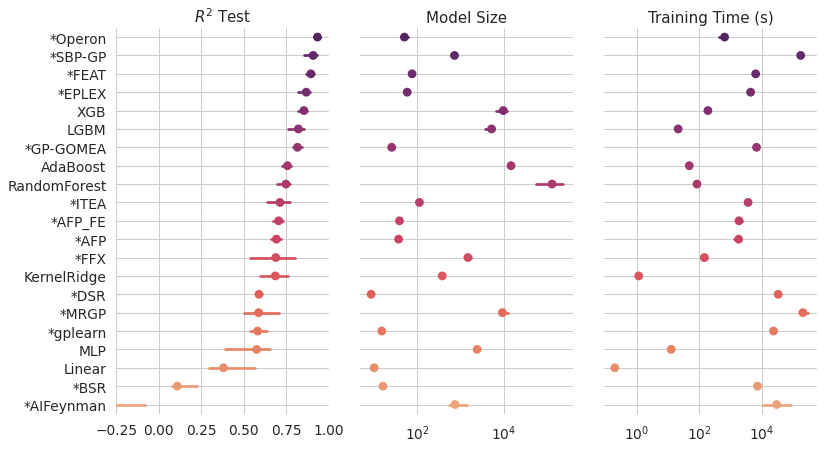

In [17]:
# Make the PairGrid
sns.set_style("whitegrid")
df_plot=df_sum.copy()

df_plot['*algorithm*'] = df_plot['algorithm'].apply(lambda x: '*'+x if x in symbolic_algs else x)
# df_plot['norm_mse_test'] = df_plot.groupby('dataset')['r2_test'].apply(lambda x: (x-x.min())/(x.max()-x.min()))
# order = df_plot.groupby('*algorithm*')['r2_test'].median().sort_values(ascending=False).index
# order = df_plot.groupby('*algorithm*')['norm_r2_test'].median().sort_values(ascending=False).index
x_vars=[
#         'rmse_test',
#         'log_mse_test',
#         'r2_test_norm',
#         'r2_zero_test',
        'r2_test',
#         'r2_test_rank',
        'model_size',
#         'model_size_rank',
        'training time (s)',
#         'solution'
]
order = df_plot.groupby('*algorithm*')[x_vars[0]].median().sort_values(
                    ascending='r2' not in x_vars[0] or 'rank' in x_vars[0]).index
g = sns.PairGrid(df_plot, 
                 x_vars=x_vars,
                 y_vars=['*algorithm*'],
                 height=6.5, 
                 aspect=0.6,
#                  hue='symbolic_dataset'
                )

# Draw a dot plot using the stripplot function
# g.map(sns.stripplot, size=10, orient="h", jitter=False, order=order, alpha=0.1,
#       palette="flare_r", linewidth=1, edgecolor="w")
g.map(sns.pointplot, 
      size=10,
      orient="h",
      jitter=False,
      order=order,
      palette="flare_r",
      linewidth=1,
      markeredgecolor='w',
      join=False,
      estimator=np.median,
      n_boot=1000,
      ci=95
     )
# plt.legend()
# Use the same x axis limits on all columns and add better labels
# g.set(xlim=(0, 25), xlabel="Crashes", ylabel="")

# # Use semantically meaningful titles for the columns
# titles = ["Total crashes", "Speeding crashes", "Alcohol crashes",
#           "Not distracted crashes", "No previous crashes"]
titles = [x.replace('_',' ').title().replace('(S)','(s)').replace('R2','$R^2$') for x in x_vars]
g.axes.flat[0].set_ylabel('')
for ax, title in zip(g.axes.flat, titles):

    # Set a different title for each axes
    ax.set(title=title)
    ax.set_xlabel('')
    
    if any([n in title.lower() for n in ['size','time']]):
        ax.set_xscale('log')
    
    if title == '$R^2$ Test':
        ax.set_xlim([-.25,1])

    # Make the grid horizontal instead of vertical
#     ax.xaxis.grid(True)
    ax.yaxis.grid(True)

sns.despine(left=True, bottom=True)

save(name='_'.join(['pairgrid-pointplot']+x_vars))

## effect of friedman datasets

In [18]:
datasets = df_sum.dataset.unique()
print(len(datasets))
friedman_datasets = [d for d in datasets if '_fri_' in d]
print(len(friedman_datasets))
print(friedman_datasets)

122
62
['579_fri_c0_250_5', '581_fri_c3_500_25', '582_fri_c1_500_25', '583_fri_c1_1000_50', '584_fri_c4_500_25', '586_fri_c3_1000_25', '588_fri_c4_1000_100', '589_fri_c2_1000_25', '590_fri_c0_1000_50', '591_fri_c1_100_10', '592_fri_c4_1000_25', '593_fri_c1_1000_10', '594_fri_c2_100_5', '595_fri_c0_1000_10', '596_fri_c2_250_5', '597_fri_c2_500_5', '598_fri_c0_1000_25', '599_fri_c2_1000_5', '601_fri_c1_250_5', '602_fri_c3_250_10', '603_fri_c0_250_50', '604_fri_c4_500_10', '605_fri_c2_250_25', '606_fri_c2_1000_10', '607_fri_c4_1000_50', '608_fri_c3_1000_10', '609_fri_c0_1000_5', '611_fri_c3_100_5', '612_fri_c1_1000_5', '613_fri_c3_250_5', '615_fri_c4_250_10', '616_fri_c4_500_50', '617_fri_c3_500_5', '618_fri_c3_1000_50', '620_fri_c1_1000_25', '621_fri_c0_100_10', '622_fri_c2_1000_50', '623_fri_c4_1000_10', '624_fri_c0_100_5', '626_fri_c2_500_50', '627_fri_c2_500_10', '628_fri_c3_1000_5', '631_fri_c1_500_5', '633_fri_c0_500_25', '634_fri_c2_100_10', '635_fri_c0_250_10', '637_fri_c1_500_50'

In [19]:

df_plot=df_sum.copy()
df_plot['*algorithm*'] = df_plot['algorithm'].apply(lambda x: '*'+x if x in symbolic_algs else x)
df_plot = df_plot[['*algorithm*','r2_test_rank','friedman_dataset']]
pd.melt(df_plot, id_vars=['friedman_dataset','*algorithm*'], value_vars=['r2_test_rank'])

,friedman_dataset,*algorithm*,variable,value
0,False,*AFP,r2_test_rank,14.0
1,False,*AFP,r2_test_rank,14.0
2,False,*AFP,r2_test_rank,14.0
3,False,*AFP,r2_test_rank,15.0
4,False,*AFP,r2_test_rank,16.0
...,...,...,...,...
2542,False,*gplearn,r2_test_rank,5.0
2543,False,*gplearn,r2_test_rank,2.0
2544,False,*gplearn,r2_test_rank,5.0
2545,False,*gplearn,r2_test_rank,13.0


saving ../../paper/figs//results_pmlb_r1//friedman_comparison_pairgrid-pointplot_r2_test.pdf
saving ../../paper/figs//results_pmlb_r1//friedman_comparison_pairgrid-pointplot_normalized_R2_test.pdf
saving ../../paper/figs//results_pmlb_r1//friedman_comparison_pairgrid-pointplot_r2_test_rank.pdf


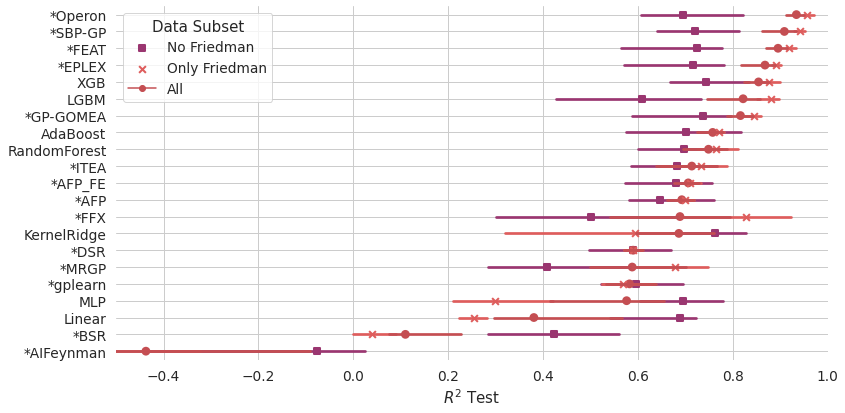

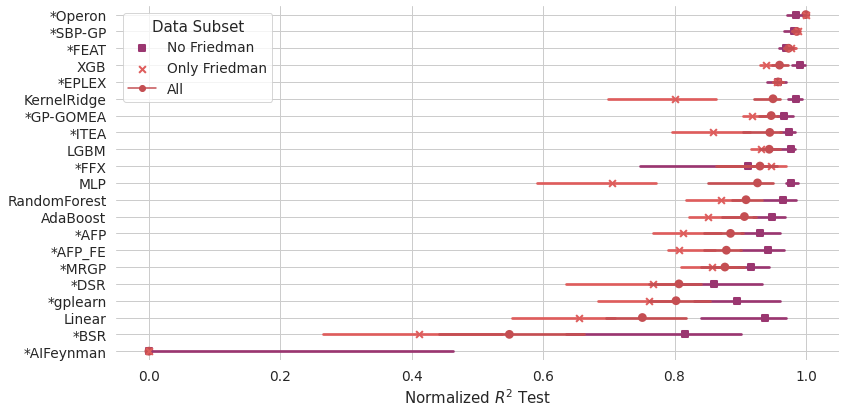

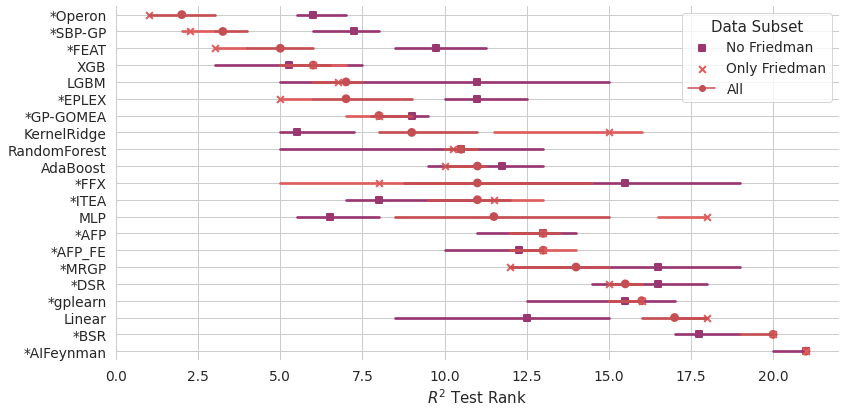

In [20]:
# Make the PairGrid
sns.set_style("whitegrid")
df_plot=df_sum.copy()
df_plot['*algorithm*'] = df_plot['algorithm'].apply(lambda x: '*'+x if x in symbolic_algs else x)
df_plot = df_plot[['*algorithm*','r2_test','r2_test_norm','r2_test_rank','friedman_dataset']]

x='r2_test'
markers = ['o','s','x']
colors = sns.color_palette('flare',n_colors=3)
for x in ['r2_test','r2_test_norm','r2_test_rank']:
# for x in ['r2_test']:
    h = plt.figure(figsize=(12,6))
    ax = plt.gca()
    order = df_plot.groupby('*algorithm*')[x].median().sort_values(
                    ascending='r2' not in x or 'rank' in x).index
    i = 0
    axes = []
    g = sns.pointplot(ax=ax,
                  data=df_plot,
                  x=x,
                  y='*algorithm*',
                  hue='friedman_dataset',
                  size=10,
                  orient="h",
                  order=order,
                  markers=['s','x'],
                  palette="flare_r",
                  join=False,
                  estimator=np.median,
                  legend_out=True
                 )
#     leg = g._legend
    # all PMLB
    g2 = sns.pointplot(ax=ax,
                  data=df_plot,
                  x=x,
                  y='*algorithm*',
#                   hue='friedman_dataset',
                  size=10,
                  orient="h",
                  order=order,
                  color='r',
#                   palette="flare_r",
                  join=False,
                  estimator=np.median,
                  markers = ['o'],
                  legend_out=True
                 )
    # add all PMLB to legend
    handles, labels = ax.get_legend_handles_labels()
    #Create custom artists
    both = plt.Line2D((0,1),(0,0), color='r', marker='o', linestyle='-', label='All')
    handles.append(both)
    plt.legend(title='Data Subset',
               handles=handles, 
               labels=['No Friedman','Only Friedman','All'])
    
    if x=='r2_test':
        plt.xlim([-.5,1.0])
    if 'norm' in x:
        x='normalized_R2_test'
    sns.despine(left=True, bottom=True)
#         plt.title(prefix.replace('_',' ').title())
    axes.append(ax)
    i+=1
    plt.tight_layout()
    for ax in axes:
        ax.set_ylabel('')
        ax.set_xlabel(x.replace('_',' ').title().replace('(S)','(s)').replace('R2','$R^2$'))
        ax.yaxis.grid(True)
        ax.xaxis.grid(True)


    save(name='friedman_comparison_'+'_'.join(['pairgrid-pointplot']+[x]))

In [21]:
# leg = g.get_legend() #.__dict__
# leg.legendHandles[0].__dict__
# leg.__dict__
g2.legend_.__dict__ #.legendHandles[0].__dict__

{'_stale': False,
 'stale_callback': <function matplotlib.artist._stale_axes_callback(self, val)>,
 '_axes': <AxesSubplot:xlabel='$R^2$ Test Rank'>,
 'figure': <Figure size 864x432 with 1 Axes>,
 '_transform': <matplotlib.transforms.IdentityTransform at 0x7f37a58d9e20>,
 '_transformSet': False,
 '_visible': True,
 '_animated': False,
 '_alpha': None,
 'clipbox': None,
 '_clippath': None,
 '_clipon': True,
 '_label': '',
 '_picker': None,
 '_contains': None,
 '_rasterized': None,
 '_agg_filter': None,
 '_mouseover': False,
 'eventson': False,
 '_oid': 0,
 '_propobservers': {},
 '_remove_method': <bound method Axes._remove_legend of <AxesSubplot:xlabel='$R^2$ Test Rank'>>,
 '_url': None,
 '_gid': None,
 '_snap': None,
 '_sketch': None,
 '_path_effects': [],
 '_sticky_edges': _XYPair(x=[], y=[]),
 '_in_layout': True,
 'prop': <matplotlib.font_manager.FontProperties at 0x7f377959e190>,
 '_fontsize': 13.75,
 'texts': [Text(0, 0, 'No Friedman'),
  Text(0, 0, 'Only Friedman'),
  Text(0, 0, 'A

# training time versus dataset size

In [22]:
import pandas as pd
# for dataset, dfg in df_sum.groupby('dataset'):
def get_size(dataset,i):
    datadir = '../../../pmlb/datasets/'
    df = pd.read_csv(datadir+dataset+'/'+dataset+'.tsv.gz',sep='\t') 
    return df.shape[i]
df_sum.loc[:,'dataset_nsamples'] = df_sum['dataset'].apply(lambda x: get_size(x,0))
df_sum.loc[:,'dataset_nsamples_train'] = df_sum['dataset'].apply(lambda x: min(get_size(x,0),10000))
df_sum.loc[:,'dataset_nfeatures'] = df_sum['dataset'].apply(lambda x: get_size(x,1))
df_sum.loc[:,'dataset_npoints'] = df_sum['dataset_nsamples']*df_sum['dataset_nfeatures']
df_sum

,algorithm,dataset,random_state,training time (s),model_size,mse_test,mae_test,r2_test,training time (hr),r2_zero_test,...,r2_zero_test_rank,r2_zero_test_norm,rmse_test_rank,rmse_test_norm,log_mse_test_rank,log_mse_test_norm,dataset_nsamples,dataset_nsamples_train,dataset_nfeatures,dataset_npoints
0,AFP,1027_ESL,13879.5,1210.966865,20.5,0.365049,0.442612,0.830930,0.336380,0.830930,...,14.0,0.922184,14.0,0.139514,14.0,0.123830,488,488,5,2440
1,AFP,1028_SWD,13879.5,3017.658321,47.0,0.438023,0.538419,0.314517,0.838238,0.314517,...,14.0,0.836660,17.0,0.216281,17.0,0.208446,1000,1000,11,11000
2,AFP,1029_LEV,13879.5,2622.206193,23.5,0.433124,0.508817,0.521904,0.728391,0.521904,...,14.0,0.934869,14.0,0.075124,14.0,0.070675,1000,1000,5,5000
3,AFP,1030_ERA,13879.5,3007.024177,36.5,2.496171,1.299746,0.358716,0.835284,0.358716,...,15.0,0.917586,16.0,0.066810,16.0,0.070855,1000,1000,5,5000
4,AFP,1089_USCrime,13879.5,590.939726,25.0,549.423049,18.823004,0.639671,0.164150,0.639671,...,16.0,0.780937,15.0,0.200320,15.0,0.286474,47,47,14,658
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2542,gplearn,695_chatfield_4,13879.5,28398.484904,1.0,311.234213,11.696317,0.843542,7.888468,0.843542,...,5.0,0.974512,6.0,0.010673,6.0,0.038788,235,235,13,3055
2543,gplearn,706_sleuth_case1202,13879.5,22506.032915,11.5,3185.450642,40.642813,0.661283,6.251676,0.661283,...,2.0,0.994737,3.0,0.009024,3.0,0.029265,93,93,7,651
2544,gplearn,712_chscase_geyser1,13879.5,26863.988673,3.0,36.237705,4.901875,0.760493,7.462219,0.760493,...,5.0,0.993841,1.0,0.000000,1.0,0.000000,222,222,3,666
2545,gplearn,banana,13879.5,31580.997657,33.5,0.421351,0.430139,0.571803,8.772499,0.571803,...,13.0,0.786982,13.0,0.158092,13.0,0.142943,5300,5300,3,15900


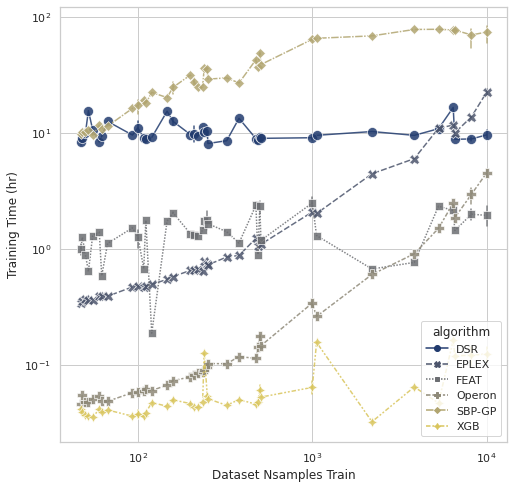

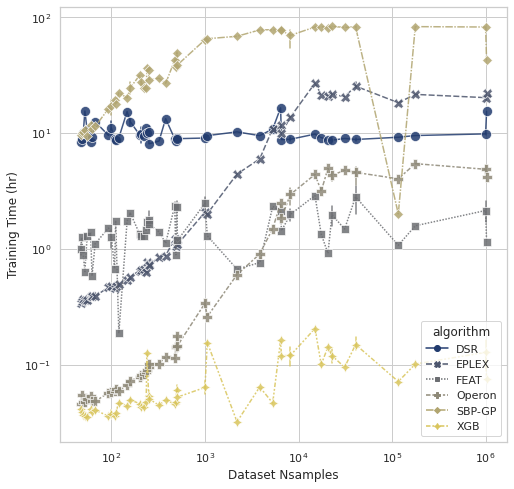

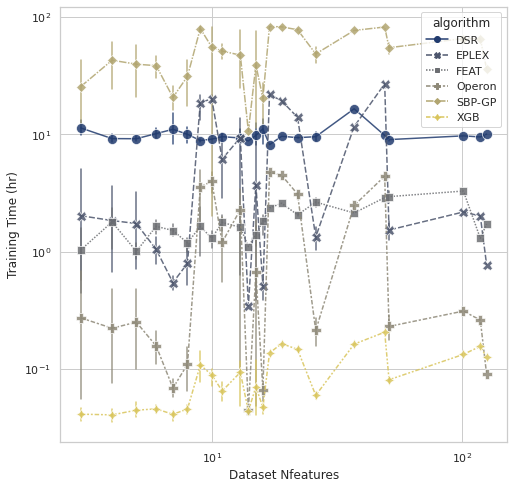

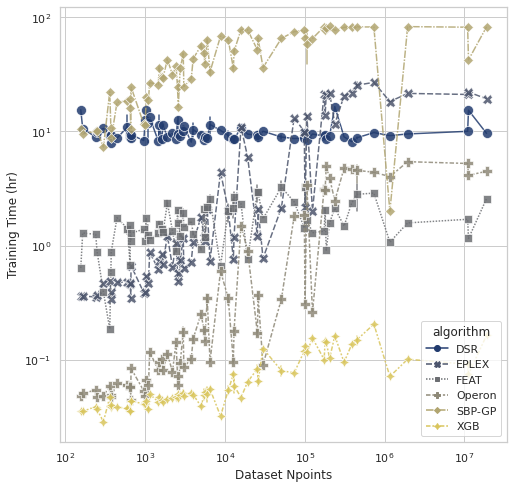

In [34]:
df_sum['Method Family'] = df_sum['algorithm'].apply(lambda x: 'Operon' if x=='Operon' else 'XGB' if x=='XGB' else 'Other Non-GP SR' if x in nongp_algs else 'Other GP SR' if x in gp_algs else 'Other ML')
sns.set_style('whitegrid')
for col in ['dataset_nsamples_train','dataset_nsamples','dataset_nfeatures','dataset_npoints']:
    plt.figure(figsize=(8,8))
    ax = sns.lineplot(
        data=df_sum.loc[df_sum.algorithm.isin(['Operon',
                                               'FEAT',
                                               'EPLEX',
                                               'SBP-GP',
                                               'XGB',
                                               'DSR',
                                               ])],
        x = col,
        y = 'training time (hr)',
#         hue='Method Family',
#         style='Method Family',
        hue='algorithm',
        style='algorithm',
        markers=True,
        palette='cividis',
        markersize=10,
        markerfacecolor=None,
        err_style='bars',
        alpha=0.85
#         facecolors=None
#         scatter_kws = {'facecolors':'none'}
    )
    ax.set_yscale('log')
    ax.set_xscale('log')
#     plt.legend(loc=[1.01,0])
    plt.xlabel(col.replace('_',' ').title())
    plt.ylabel('Training Time (hr)')
    plt.savefig('../../paper/figs/training_time_'+col+'.pdf',dpi=400)

In [24]:
## missing feynman runs

In [25]:
datasets = df_sum.dataset.unique()
df_feyn = df_sum.loc[df_sum.algorithm=='AIFeynman']
feyn_datasets = df_feyn.dataset.unique()
missing = []
for d in datasets:
    if d not in feyn_datasets:
        missing.append(d)
missing

['1191_BNG_pbc',
 '197_cpu_act',
 '201_pol',
 '294_satellite_image',
 '4544_GeographicalOriginalofMusic',
 '505_tecator',
 '573_cpu_act',
 '574_house_16H',
 '581_fri_c3_500_25',
 '583_fri_c1_1000_50',
 '584_fri_c4_500_25',
 '586_fri_c3_1000_25',
 '588_fri_c4_1000_100',
 '592_fri_c4_1000_25',
 '622_fri_c2_1000_50']

<!-- # scores on symbolic datasets (prelim) -->

# Pareto plot

TODO: label the pareto set with text names next to points

In [26]:
np.random.seed(42)
def bootstrap(val, n = 1000, fn=np.mean):
    val_samples = []
    for i in range(n):
        sample = np.random.randint(0,len(val)-1, size=len(val))
        val_samples.append( fn(val[sample]) )
    m = np.mean(val_samples)
    sd = np.std(val_samples)
    ci_upper  = np.quantile(val_samples,0.95)
    ci_lower  = np.quantile(val_samples,0.05)
    return m, sd, ci_upper,ci_lower

saving ../../paper/figs//results_pmlb_r1//pareto_plot_r2_test_rank_model_size_rank.pdf


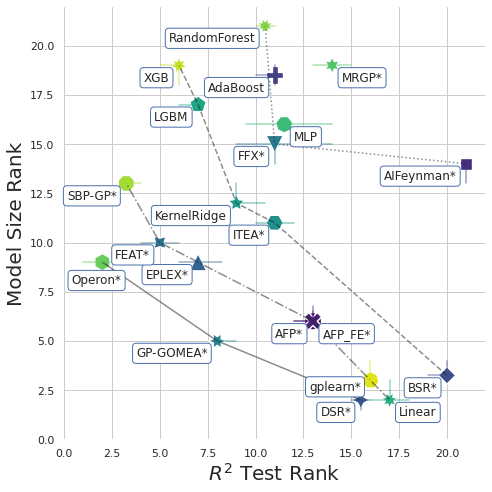

In [27]:
from pareto_utils import front
sns.set(font_scale=1, style='whitegrid')
labelsize=20
plt.figure(figsize=(7,7))
data = df_sum.copy() #.loc[df_sum.algorithm.isin(symbolic_algs)]
data['*algorithm*'] = data['algorithm'].apply(lambda x: x+'*' if x in symbolic_algs else x)
xcol = 'r2_test_rank'
ycol = 'model_size_rank'
palette = 'viridis'
cmap = sns.color_palette(palette=palette, n_colors=data.algorithm.nunique(), desat=None, as_cmap=False)
Z = 1.96 # 95% confidence 
i = 0
for alg, dg in data.groupby('*algorithm*'):
    x = dg[xcol].median() 
    y = dg[ycol].median()
    _, sdx, ciux, cilx = bootstrap(dg[xcol].values, fn=np.median, n=1000)
    _, sdy, ciuy, cily = bootstrap(dg[ycol].values, fn=np.median, n=1000)
#     sdx = Z*dg[xcol].std()/np.sqrt(len(dg))
#     iqrx = dg[xcol].quantile(0.75) - dg[xcol].quantile(0.25)
#     sdy = Z*dg[ycol].std()/np.sqrt(len(dg))
#     iqry = dg[ycol].quantile(0.75) - dg[ycol].quantile(0.25)
    plt.plot(
#              [x-sdx,x+sdx],
             [cilx,ciux],
             [y, y],
             alpha=0.5,
             color=cmap[i]
            )
    plt.plot(
             [x, x],
#              [y-sdy,y+sdy],
             [cily,ciuy],
             alpha=0.5,
             color=cmap[i]
            )
    i += 1
# outline pareto front
pareto_data = data.groupby('*algorithm*').median()
objs = pareto_data[[xcol,ycol]].values
levels = 4
styles=['-','-.','--',':']
PFs = []
for el in range(levels):
    PF = front(objs[:,0],objs[:,1])
    objs[PF,:] = 100
    PFs.append(PF)
# PF = front(pareto_data[xcol].values, pareto_data[ycol].values)
# import pdb 
# pdb.set_trace()
# idx = [i for i in range(len(objs)) if not i in PF]
# pdb.set_trace()
# PF2 = front(objs[:,0], 
#             objs[:,1])
# print('PF2:',PF2)
i = 0
for pfset in PFs:
    xset,yset = [],[]

    for pf in pfset:
        xset.append(pareto_data[xcol].values[pf])
        yset.append( pareto_data[ycol].values[pf] )
    linestyle=styles[i]
    plt.plot(xset,yset, styles[i]+'k', alpha=0.5, zorder=1)
    plt.gca().set_zorder(10)
    i+=1

ax = sns.scatterplot(
    ax = plt.gca(),
#     ax = g.ax_joint,
    data = data.groupby('*algorithm*').median(),
    x = xcol,
    y = ycol,
    style='*algorithm*',
    hue = '*algorithm*',
    s=300,
    palette=palette,
    #     edgecolor='k'
    legend=False,
)
ax.set_zorder(2)
xoff = .5
yoff = 0.3
for idx,row in pareto_data.iterrows():
    x=row[xcol]-xoff
    y=row[ycol]-yoff
    ha='right'
    
    if idx in ['Linear','AFP_FE*','MLP','MRGP*']:
        x=row[xcol]+xoff
        ha='left'
    elif idx == 'Operon*':
        x = row[xcol]+1
        y -= yoff
        ha='right'
    elif idx == 'gplearn*':
        y += yoff
        ha='right'
        
    plt.text(s=idx,
             x = x, 
             y = y,
             ha=ha,
             va='top',
             bbox=dict(facecolor='w', edgecolor='b', boxstyle='round', alpha=1)
            )
# handles = ax.get_legend_handles_labels()[0]
# for lh in handles: 
#     lh.set_alpha(1)
#     lh._sizes = [200] 
# ax.legend(handles=handles, loc=[1.01,0.0])
# ax.set_yscale('log')
ax.set_xlim(left=0)
ax.set_ylim(bottom=0)
plt.xlabel(xcol.replace('_',' ').replace('r2','$R^2$').title(), fontsize=labelsize)
plt.ylabel(ycol.replace('_',' ').title(), fontsize=labelsize)
sns.despine(left=True, bottom=True)
save(name="pareto_plot_"+xcol+'_'+ycol)

In [28]:
df_sum.set_index(['dataset','algorithm'])['r2_test'].unstack().round(2).to_latex('../../paper/tables/all_black_box_r2_test.tex')